<a href="https://colab.research.google.com/github/gui-ferr/projetosTA/blob/main/Projetinho2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
import seaborn as sns

In [2]:
df = pd.read_csv('promocao.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


# Rápida olhada pra corrigir algumas coisas no dataset

In [3]:
print(df.describe(include=['object']))
print(df.department.unique())
print(df.previous_year_rating.unique())
print(df.education.unique())

               department    region   education gender recruitment_channel
count               54808     54808       52399  54808               54808
unique                  9        34           3      2                   3
top     Sales & Marketing  region_2  Bachelor's      m               other
freq                16840     12343       36669  38496               30446
['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
[ 5.  3.  1.  4. nan  2.]
["Master's & above" "Bachelor's" nan 'Below Secondary']


As colunas de PYR (previous year rating) e education tem NaNs. Os NaNs da PYR são de funcionarios que entraram esse ano (isso vai ser corrigido na hora de fazer os dummies). Os NaNs de education me parecem equivalentes a High School, já que existe uma classificação "Below secondary" (~ensino médio pra baixo) e uma "Bachelor's" (Faculdade) mas não uma de Ensino médio completo. Por isso, vou trocar eles por "High School".

In [4]:
df["education"].replace(np.NAN, "High School", inplace=True)
print(df.education.unique())

["Master's & above" "Bachelor's" 'High School' 'Below Secondary']


In [5]:
print(df.describe(include=['int64']))
print(df.describe(include=['float64']))

        employee_id  no_of_trainings           age  length_of_service  \
count  54808.000000     54808.000000  54808.000000       54808.000000   
mean   39195.830627         1.253011     34.803915           5.865512   
std    22586.581449         0.609264      7.660169           4.265094   
min        1.000000         1.000000     20.000000           1.000000   
25%    19669.750000         1.000000     29.000000           3.000000   
50%    39225.500000         1.000000     33.000000           5.000000   
75%    58730.500000         1.000000     39.000000           7.000000   
max    78298.000000        10.000000     60.000000          37.000000   

        awards_won?  avg_training_score   is_promoted  
count  54808.000000        54808.000000  54808.000000  
mean       0.023172           63.386750      0.085170  
std        0.150450           13.371559      0.279137  
min        0.000000           39.000000      0.000000  
25%        0.000000           51.000000      0.000000  
50%   

In [8]:
#Vou dropar a coluna de ID porque não vai ajudar em nada
df = df.drop(['employee_id'],axis=1)

Heatmap pra checar algumas correlações entre as variáveis:

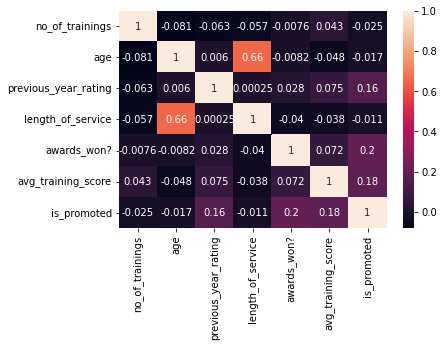

In [9]:
sns.heatmap(df.corr(),xticklabels=True, yticklabels=True, annot=True)

Se percebe que a nota do ano passado, prêmios e a média das notas de treino são as variávies com mais correlação com a promoção, enquanto a idade, o número de treinamentos e o tempo na empresa parecem não ter correlação nenhuma com a chance de ser promovido! 
A mais surpreendente dessas informações foi a de tempo na empresa: o senso comum acredita que mais tempo trabalhando em uma empresa significa promoção e salário maior, mas pelo visto isso não é uma regra.

#Regressão Logística

Primeiro o encoding:

In [10]:
df_dummy = pd.get_dummies(df, prefix = ['previous_year_rating','department','region','education','gender','recruitment_channel'], dummy_na=True, columns = ['previous_year_rating','department','region','education','gender','recruitment_channel'])

In [11]:
colunas_dummy = list(df_dummy.columns.values)
colunas_dummy.remove('is_promoted')
print(colunas_dummy)

['no_of_trainings', 'age', 'length_of_service', 'awards_won?', 'avg_training_score', 'previous_year_rating_1.0', 'previous_year_rating_2.0', 'previous_year_rating_3.0', 'previous_year_rating_4.0', 'previous_year_rating_5.0', 'previous_year_rating_nan', 'department_Analytics', 'department_Finance', 'department_HR', 'department_Legal', 'department_Operations', 'department_Procurement', 'department_R&D', 'department_Sales & Marketing', 'department_Technology', 'department_nan', 'region_region_1', 'region_region_10', 'region_region_11', 'region_region_12', 'region_region_13', 'region_region_14', 'region_region_15', 'region_region_16', 'region_region_17', 'region_region_18', 'region_region_19', 'region_region_2', 'region_region_20', 'region_region_21', 'region_region_22', 'region_region_23', 'region_region_24', 'region_region_25', 'region_region_26', 'region_region_27', 'region_region_28', 'region_region_29', 'region_region_3', 'region_region_30', 'region_region_31', 'region_region_32', 're

Separação de dados de treino e teste:

In [12]:
X = df_dummy[colunas_dummy]
y = df_dummy['is_promoted']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

Agora sim fazer o treino:

In [14]:
logreg = LogisticRegression(solver='liblinear')
scores = cross_val_score(logreg, X_train, y=y_train, cv = 10, scoring='accuracy')
scores.mean()

0.9364524607146866

Testar se isso é overfitting com os dados de validação:

In [15]:
logreg.fit(X_train, y_train)
y_pred_logr = logreg.predict(X_test)

print(accuracy_score(y_test, y_pred_logr))

0.9379067080216505


#SVM

Treino do SVM:

In [ ]:
svm = svm.SVC(C = 1E3)
scores = cross_val_score(svm, X_train, y=y_train, cv = 5, scoring='accuracy')
scores.mean()

0.9135149224553629

In [ ]:
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

Teste pra validação:

In [ ]:
print(accuracy_score(y_test, y_pred_svm))

0.9178981937602627
